# Assignment 3
**Samuel Sheehy (Student ID 18143565)**

**Techniques of High Performance Computing (PHAS0102)**

**MSc Scientific Computing, University College London**, **2019-2020**

This Jupyter Notebook is submitted as completion of the 3rd Assignment for the UCL course cited above.

## Setup
This cell imports the libraries and defines the helper functions
that will be used for the entirety of the assignment.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyopencl as cl

from math import ceil
from numba import njit
from scipy.sparse.linalg import LinearOperator, cg
from scipy.sparse import coo_matrix

# User-define helper functions
class Timer:
    """
    A simple timer class to measure the execution time
    of a function (seconds) in a ```with``` block.
    Taken from module lecture notes.
    """
    def __enter__(self):
        """
        Measure time at start.
        """
        self.start = time.time()
        return self

    def __exit__(self, *args):
        """
        Measure time at end and take difference
        from start.
        """
        self.end = time.time()
        self.interval = self.end - self.start

        
def bytesize(N, dtype_str):
    """
    Returns the number of bytes that an array of element
    size N occupies
    """
    return np.dtype(dtype_str).itemsize*N

## Question 1: Investigating Splitting Schemes
 Boundary Conditions:
 * $u(x, 0) = 1$
 * $u(0, y) = 0$
 * $u(1, y) = 0$
 * $u(x, 1) = 0$

* Implement Jacobi iteration:
    - Parallelised OpenCL kernel
    - System solved through repeated cals
* Implement Gauss-Seidel: two different schemes: one starting with nodes at the bottom of the square and proceeding line by line, and two: start at the top and prodeed line by line to the bottom.
    - Numba accelerated version of GS

* Implement relaxed GS: updaes a single row in parallel with updated values from the previous row
    - Parallelised across a single row
    - OpenCL kernel

* Compare convergences of GS and relaxed GS

### Jacobi Iteration
$$
u_{ij}^{(n+1)} = \frac{
u_{i-1, j}^{(n)} +
u_{i+1, j}^{(n)} +
u_{i, j-1}^{(n)} +
u_{i, j+1}^{(n)} }{4}
$$

In [2]:
# while norm{U(+1) - U} > tol; do
# U(+1) = OP(U)

# OP such that above is true

In [3]:
class JacobiIterator(LinearOperator):
    """
    Implements an OpenCL-accelerated Linear Operator for
    perforing the Jacobi Iteration of of a 5-point stencil
    in the Laplacian problem for a unit square.
    """
    def __init__(self, M, left, right, top, bottom, data_type):
        """
        Creates the linear operator for M points per side
        and with the given boundary conditions.
        """
        # Setup parameters (required by parent class)
        self.shape = ((M-2)**2, (M-2)**2)
        self.dtype =  np.dtype(data_type)
        self.explicit = False
        # Create the OpenCL kernel
        self._openCL_matvec = init_Jacobi_kernel(M, left, right, top, bottom)

    def _matvec(self, x):
        """
        Apply the Linear Operator to the vector x
        """
        return self._openCL_matvec(x)


def init_Jacobi_kernel(M, left, right, top, bottom):
    """
    Initialises an OpenCl kernel that implements a Jacobi Iterator
    for solving the Laplacian problem on a unit square,
    discretised into M points per side and with the given boundary
    conditions.
    """
    Mop = (M-2)**2
    # OpenCL kernel 
    kernel = """
        __kernel void matvec(
            __global double *vector,
            __global double *result,
            __global double *left,
            __global double *right,
            __global double *top,
            __global double *bottom,
            int N
        ){        
            // Get Global Identifiers i.e. the row index
            int row_index = get_global_id(0);
            int col_index = get_global_id(1);

            double left_val;
            double right_val;
            double top_val;
            double bottom_val;
            
            if (col_index == 0)
                left_val = left[row_index];
            else
                left_val = vector[N * row_index + col_index - 1];

            if (col_index == N-1)
                right_val = right[row_index];
            else
                right_val = vector[N * row_index + col_index + 1];

            if (row_index == 0)
                top_val = top[col_index];
            else
                top_val = vector[N * (row_index - 1) + col_index];

            if (row_index == N-1)
                bottom_val = bottom[col_index];
            else
                bottom_val = vector[N * (row_index + 1) + col_index];

            result[row_index * N + col_index] = 0.25*(left_val + right_val + top_val + bottom_val);
        }
    """
    # Initialise the OpenCL environment
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags
    
    # Create buffers
    vector_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, bytesize(Mop, 'float64'))
    result_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, bytesize(Mop, 'float64'))
    left_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=left)
    right_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=right)
    top_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=top)
    bottom_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=bottom)
    
    # Build the Kernel
    prg = cl.Program(ctx, kernel)
    prg.build()
    matvec_kernel = prg.matvec
    
    # Define Execution Function
    def kernel_exec(x):
        """
        Executes the created OpenCl kernel with the array x.
        """
        # Load vector x
        mapped_input, _ = cl.enqueue_map_buffer(queue, vector_buffer, cl.map_flags.WRITE, 
                                             0, Mop, 'float64')
        
        with mapped_input.base:
            mapped_input[:] = x.astype('float64')
        
        
        # Run the kernel
        matvec_kernel(
            # Workspace parameters
            queue, (M-2, M-2), None,
            # Buffers
            vector_buffer, result_buffer,
            left_buffer, right_buffer, top_buffer, bottom_buffer,
            np.int32(M-2)
        )
        
        # read and return result
        result = np.empty(Mop, dtype='float64')
        cl.enqueue_copy(queue, result, result_buffer)
        queue.finish()
        
        return result
    
    return kernel_exec

#### Solving 

29637 9.996943594831377e-09


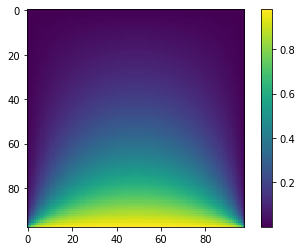

In [4]:
max_k = 1e5

def discretise_bc(low, high, M, f):
    x = np.linspace(low, high, M)
    fx = np.array([f(xi) for xi in x], dtype='float64')
    return fx

# Define the boundary conditions
left_bc = lambda y: 0
right_bc = lambda y: 0
top_bc = lambda x: 0
bottom_bc = lambda x: 1
# Discretize into M points
M = 100
# Create result array, excluding boundaries
Mop = (M-2)**2
left_points = discretise_bc(0, 1, M, left_bc)
right_points = discretise_bc(0, 1, M, right_bc)
top_points = discretise_bc(0, 1, M, top_bc)
bottom_points = discretise_bc(0, 1, M, bottom_bc)
# Create LOP that is aware of boundary conditions
jlop = JacobiIterator(M, left_points[1:-1], right_points[1:-1],
                      top_points[1:-1], bottom_points[1:-1], 'float64')

# get ready
tol = 1e-8
result_old = np.zeros(Mop)
result_new = np.ones(Mop)
# iterate
k = 0
diff = lambda a, b: np.linalg.norm(a - b)
while diff(result_old, result_new) > tol:
    result_old = result_new
    result_new = jlop.matvec(result_new)
    k += 1
    if k > max_k:
        break
print(k, diff(result_old, result_new))


plt.imshow(result_new.reshape((M-2, M-2)))
plt.colorbar()
plt.show()


### Gauss-Seidel Iteration (Schemes 1 & 2)


In [5]:
# for each iteration:
#  for point in stencil: 
#    update
#  measure difference, stop if tolerance met

134 9.822812726878072e-06


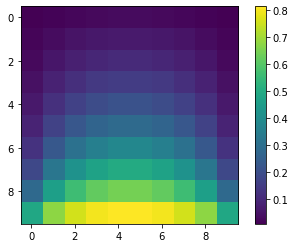

In [6]:
@njit
def gs():
    M = 10
    tol = 1e-5
    descending = True
    max_k = 10000

    old_lattice = np.zeros((M, M))
    lattice = old_lattice + 1

    k = 0

    if not descending:
        myrange = range(0, M)
    else:
        myrange = range(M-1, -1, -1)

    while np.linalg.norm(old_lattice - lattice) > tol:
        old_lattice[:] = lattice[:]
        for row in myrange:
            for col in myrange:
                #x = input('cont?')
                if row == 0:
                    top = 0
                else:
                    top = lattice[row-1, col]
                if row == M-1:
                    bottom = 1
                else:
                    bottom = lattice[row+1, col]
                if col == 0:
                    left = 0
                else:
                    left = lattice[row, col-1]
                if col == M-1:
                    right = 0
                else:
                    right = lattice[row, col+1]

                lattice[row, col] = 0.25*(left + right + top + bottom)
        if k > max_k:
            break
        k += 1
        
    print(k, np.linalg.norm(old_lattice - lattice))

    return lattice

lattice = gs()



plt.imshow(lattice)
plt.colorbar()
plt.show()

### Relaxed Gauss-Seidel Iteration

In [7]:
# for each iteration
# for each element (parallelised with OpenCL):
#     update corresponding element in next row

In [8]:
class RelaxedGaussSeidel(LinearOperator):
    """
    Implements an OpenCL-accelerated Linear Operator for
    performing a relaxed Gauss-Seidel iteration of of a 5-point stencil
    in the Laplacian problem for a unit square.
    """
    def __init__(self, M, left, right, top, bottom, data_type):
        """
        Creates the linear operator for M points per side
        and with the given boundary conditions.
        """
        # Setup parameters (required by parent class)
        self.shape = ((M-2), (M-2)**2)
        self.dtype =  np.dtype(data_type)
        self.explicit = False
        # Create the OpenCL kernel
        self._openCL_matvec = init_relaxedGS_kernel(M, left, right, top, bottom)
    
    def rowvec(self, previous_row, current_row, next_row, current_row_index):
        """
        """
        return self._openCL_matvec(previous_row, current_row, next_row, current_row_index)

    def _matvec(self, x):
        """
        Apply the Linear Operator to the vector x
        """
        return self._openCL_matvec(x)


def init_relaxedGS_kernel(M, left, right, top, bottom):
    """
    Initialises an OpenCl kernel that implements a Jacobi Iterator
    for solving the Laplacian problem on a unit square,
    discretised into M points per side and with the given boundary
    conditions.
    """
    Mop = M-2
    # OpenCL kernel 
    kernel = """
        __kernel void matvec(
            __global double *previous_row,
            __global double *current_row,
            __global double *next_row,
            __global double *result,
            __global double *left,
            __global double *right,            
            __global double *top,
            __global double *bottom,
            int row_index,
            int N
        ){        
            // Get Global Identifiers i.e. the row index
            int col_index = get_global_id(0);

            double top_val;
            double bottom_val;
            double left_val;
            double right_val;
            
            
            if (col_index == 0)
                left_val = left[row_index];
            else
                left_val = current_row[col_index - 1];

            if (col_index == N-1)
                right_val = right[row_index];
            else
                right_val = current_row[col_index + 1];

            if (row_index == 0)
                top_val = top[col_index];
            else
                top_val = previous_row[col_index];

            if (row_index == N-1)
                bottom_val = bottom[col_index];
            else
                bottom_val = next_row[col_index];

            result[col_index] = 0.25*(left_val + right_val + top_val + bottom_val);
        }
    """
    # Initialise the OpenCL environment
    ctx = cl.create_some_context()
    queue = cl.CommandQueue(ctx)
    mf = cl.mem_flags
    
    # Create buffers
    previous_row_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, bytesize(Mop, 'float64'))
    current_row_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, bytesize(Mop, 'float64'))
    next_row_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, bytesize(Mop, 'float64'))
    result_buffer = cl.Buffer(ctx, mf.ALLOC_HOST_PTR, bytesize(Mop, 'float64'))
    left_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=left)
    right_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=right)
    top_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=top)
    bottom_buffer = cl.Buffer(ctx, mf.COPY_HOST_PTR | mf.READ_ONLY, hostbuf=bottom)
    
    # Build the Kernel
    prg = cl.Program(ctx, kernel)
    prg.build()
    matvec_kernel = prg.matvec
    
    # Define Execution Function
    def kernel_exec(previous_row, current_row, next_row, current_row_index):
        """
        Executes the created OpenCl kernel with the array x.
        """
        # Load previous row
        mapped_input, _ = cl.enqueue_map_buffer(queue, previous_row_buffer, cl.map_flags.WRITE, 
                                             0, Mop, 'float64')
        with mapped_input.base:
            mapped_input[:] = previous_row.astype('float64')
        
        mapped_input, _ = cl.enqueue_map_buffer(queue, current_row_buffer, cl.map_flags.WRITE, 
                                             0, Mop, 'float64')
        with mapped_input.base:
            mapped_input[:] = current_row.astype('float64')

        mapped_input, _ = cl.enqueue_map_buffer(queue, next_row_buffer, cl.map_flags.WRITE, 
                                             0, Mop, 'float64')
        with mapped_input.base:
            mapped_input[:] = next_row.astype('float64')
        
        
        # Run the kernel
        matvec_kernel(
            # Workspace parameters
            queue, (Mop,), None,
            # Buffers
            previous_row_buffer,
            current_row_buffer,
            next_row_buffer,
            result_buffer,
            left_buffer, right_buffer,
            top_buffer, bottom_buffer,
            np.int32(current_row_index),
            np.int32(Mop)
        )
        
        # read and return result
        result = np.empty(Mop, dtype='float64')
        cl.enqueue_copy(queue, result, result_buffer)
        queue.finish()
        
        return result
    
    return kernel_exec

317 9.670533799810888e-09


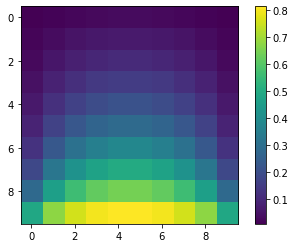

In [9]:
max_k = 1e5

def discretise_bc(low, high, M, f):
    x = np.linspace(low, high, M)
    fx = np.array([f(xi) for xi in x], dtype='float64')
    return fx

# Define the boundary conditions
left_bc = lambda y: 0
right_bc = lambda y: 0
top_bc = lambda x: 0
bottom_bc = lambda x: 1
# Discretize into M points
M = 12
# Create result array, excluding boundaries
Mop = (M-2)**2
left_points = discretise_bc(0, 1, M, left_bc)
right_points = discretise_bc(0, 1, M, right_bc)
top_points = discretise_bc(0, 1, M, top_bc)
bottom_points = discretise_bc(0, 1, M, bottom_bc)
# Create LOP that is aware of boundary conditions - CHANGE FROM SCIPY LOP TO ITS OWN LOP
rgslop = RelaxedGaussSeidel(M, left_points[1:-1], right_points[1:-1],
                      top_points[1:-1], bottom_points[1:-1], 'float64')

# get ready
tol = 1e-8
result_old = np.zeros((M-2, M-2))
result_new = np.ones((M-2, M-2))
# iterate
k = 0
diff = lambda a, b: np.linalg.norm(a - b)
while diff(result_old, result_new) > tol:
    result_old = result_new.copy()
    for current_row_index, current_row in enumerate(result_new):
        previous_row = result_new[current_row_index - 1, :] if current_row_index != 0 else np.zeros(M-2)
        next_row = result_new[current_row_index + 1, :] if current_row_index != M-3 else np.zeros(M-2)
        result_new[current_row_index, :] = rgslop.rowvec(previous_row, current_row, next_row, current_row_index)
    k += 1
    if k > max_k:
        print('max k!')
        break
print(k, diff(result_old, result_new))


plt.imshow(result_new.reshape((M-2, M-2)))
plt.colorbar()
plt.show()

### Convergence Comparison: Relaxed GS vs. GS

## Question 2: Precondition Iterative Solvers
* Write a routine that for a given grid parameter $h$ generates a 5-poin stencils discretisation of this domain and for a iven boudary function f heneates the matrix A and the right hand sise b of the discrete linear system Ax = b explicelt. A must use CSR sparse format
    - Use Scipy sparse matrices - do *not* generate dense then convert
* Solve the associae linear system directly with CG and visualie the solution. Study the convergence of CG as you increase the number of discretisation points
* Use the ILU of our system matrix as an appropriate precondition and investigate for different values of the drop factos how the congergence of CG changes.


### Create 5-point stencil matrix

In [78]:
import numpy as np
import matplotlib.pyplot as plt

from math import ceil
from numba import njit
from scipy.sparse.linalg import LinearOperator, cg
from scipy.sparse import coo_matrix


def isbc(i, j, M):
    if i < M:
        if i == 0 or j == M - 1 or j == 0:
            return True
    else:
        if j == 0 or j == 2*M - 1:
            return True
        if i == M and j >= M - 1:
            return True
        if i == 2*M-1:
            return True
    return False


def isvalid(i, j, M):
    if j >= M and i < M:
        return False
    else:
        return True


def iscorner(s, i, j, M):
    if s == 0:
        if i == 0 and (j == 0 or j == M - 1):
            return True
        return False
    if s == 1:
        if i == 2*M-1 and (j == 0 or j == 2*M-1):
            return True
        if i == M + 1 and j == 2*M-1:
            return True
        return False


def build_system(M, grad, f):
    
    data = []
    rows = []
    cols = []
    
    solmap = {}
    
    Mop = 3*(M-2)**2 + 4*(M-2)
    
    b = np.ones(Mop)*grad
    
    def add(val, row, colshift):
        data.append(val)
        rows.append(row)
        if row+colshift < 0:
            raise Exception(f'Negative col index {row}: {colshift}')
        cols.append(row+colshift)
        
    k = 0
    for i in range(2*M):
        for j in range(2*M):
            if not isbc(i, j, M) and isvalid(i, j, M):
                if i <= M:
                    k = (i-1)*(M-2) + (j-1)
                else:
                    k = M*(M-2) + (i-1-M)*(2*M-2) + (j-1)
                solmap[k] = (i, j)
                # BCs
                # top
                if isbc(i+1, j, M):
                    b[k] += f(i+1, j)
                # bottom
                if isbc(i-1, j, M):
                    b[k] += f(i-1, j)
                # left
                if isbc(i, j-1, M):
                    b[k] += f(i, j-1)
                # right
                if isbc(i, j+1, M):
                    b[k] += f(i, j+1)
                ## Finite Difference coefficients
                # center
                add(4, k, 0)
                
                # if lower section:
                if i <= M:
                    # left
                    if j >= 2:
                        add(-1, k, -1)
                    
                    # right
                    if j <= M - 3:
                        add(-1, k, 1)
                    
                    # top
                    add(-1, k, M-2)
                    
                    # bottom
                    if i >= 2:
                        add(-1, k, -(M-2))
                else: # if upper section
                    # left
                    if j >= 2:
                        add(-1, k, -1)
                    
                    # right
                    if j <= 2*M-3:
                        add(-1, k, 1)
                    
                    # top
                    if i <= 2*M-3:
                        add(-1, k, 2*(M-1))
                    
                    # bottom
                    if i == M+1 and j <= M - 2:
                        add(-1, k, -(M-2))
                    elif i >= M+2:
                        add(-1, k, -2*(M-1))
                
            
    if any([x<0 for x in cols]):
        print(cols)
        raise Exception('Negative column index')

    A = coo_matrix((data, (rows, cols))).tocsr()
    
    if A.shape[0] != A.shape[1]:
        return A, b
        raise Exception(f'Matrix is not square: {A.shape}')
    
    if A.shape[0] != Mop:
        raise Exception(f'Matrix wrong size:{A.shape[0]}')
    
    return A, b, solmap

A, b, solmap = build_system(M, 0, f3)

### Solve with CG

In [81]:
def solve(A, b):

    history = []
    
    def error_calc(u):
        error = np.linalg.norm(A@u - b)
        history.append(error)
        return

    sol, info = cg(A, b, callback=error_calc)
    if info > 0:
        print('Did not converge! iter:', info)
    if info < 0:
        print('There was an error in cg')
    
    return sol, history


M = 53
Mop = 3*(M-2)**2 + 4*(M-2)

def f1(i, j):
    if i <= M-1:
        if j == M-1:
            return 1
        else:
            return 0
    else:
        if j == 2*M-1:
            return 1
        else:
            return 0

def f2(i, j):
    if i == 2*M-1:
        return 1
    else:
        return 0

def f3(i, j):
    if i == 2*M-1:
        return 1
    elif j == 0:
        return 1
    else:
        return 0

sol, history = solve(A, b)

#### Visualise

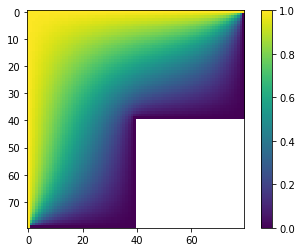

In [84]:
def show(u, M, f, solmap):
    last_row = M*(M-2)
    
    im = np.zeros((2*M, 2*M))

    for k, (i, j) in solmap.items():
#         print(k, i, j)
        im[i, j] = u[k]
    
    # bcs
    for i in range(2*M):
        for j in range(2*M):
            if isbc(i, j, M):
                im[i, j] = f(i, j)
    
    
    im[:M, M:] = np.nan
    
    im = np.flip(im, 0)
    
    plt.imshow(im)
    plt.colorbar()
    plt.show()
    return im

show(sol, M, f3, solmap);

#### Study Convergence

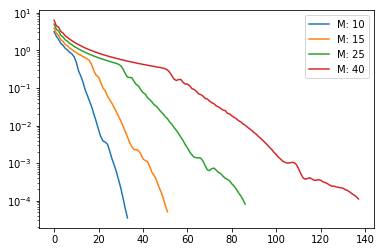

In [83]:
for M in [10, 15, 25, 40]:
    A, b, solmap = build_system(M, 0, f3)
    sol, history = solve(A, b)
    iters = [i for i, _ in enumerate(history)]
    plt.semilogy(iters, history, label='M: %s'%M)
plt.legend()
plt.show()

### Impact of ILU Preconditioner

In [ ]:
# Investigate how CG changes for different values of drop factors
# of the ILU routine